# Turbulence Models

The turbulence models in PyWake are used to calculate the added turbulence in the wake from one wind turbine to downstream turbines or sites in the wind farm. These are important when the flow properties behind the rotor must be accurately represented, for example for calculation of fatigue loading of turbine components.

**Install PyWake if needed**

In [1]:
# Install PyWake if needed
try:
    import py_wake
except ModuleNotFoundError:
    !pip install git+https://gitlab.windenergy.dtu.dk/TOPFARM/PyWake.git

First we create a simple function to plot the different turbulence models available in PyWake.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from py_wake.examples.data.hornsrev1 import V80, Hornsrev1Site

site = Hornsrev1Site()
windTurbines = V80()
wt_x, wt_y = site.initial_position.T
D = windTurbines.diameter()

In [3]:
from py_wake.wind_farm_models import All2AllIterative
from py_wake.deficit_models.deficit_model import WakeDeficitModel, BlockageDeficitModel
from py_wake.deficit_models.no_wake import NoWakeDeficit
from py_wake.site._site import UniformSite
from py_wake.flow_map import XYGrid
from py_wake.turbulence_models import CrespoHernandez
from py_wake.utils.plotting import setup_plot
from py_wake.deficit_models import NOJDeficit

def get_flow_map(model=None, grid=XYGrid(x=np.linspace(-200, 500, 200), y=np.linspace(-200, 200, 200), h=70),
                 turbulenceModel=CrespoHernandez()):
    blockage_deficitModel = [None, model][isinstance(model, BlockageDeficitModel)]
    wake_deficitModel = [NoWakeDeficit(), model][isinstance(model, WakeDeficitModel)]
    wfm = All2AllIterative(UniformSite(), V80(), wake_deficitModel=wake_deficitModel, blockage_deficitModel=blockage_deficitModel,
                           turbulenceModel=turbulenceModel)
    return wfm(x=[0], y=[0], wd=270, ws=10, yaw=0).flow_map(grid)

def plot_turb_map(model, cmap='Blues'):
    fm = get_flow_map(NOJDeficit(),turbulenceModel=model)
    fm.plot(fm.TI_eff, clabel="Added turbulence intensity [-]", levels=100, cmap=cmap, normalize_with=D)
    setup_plot(grid=False, ylabel="Crosswind distance [y/D]", xlabel="Downwind distance [x/D]",
               xlim=[fm.x.min() / D, fm.x.max() / D], ylim=[fm.y.min() / D, fm.y.max() / D], axis='auto')

### STF2005TurbulenceModel

Steen Frandsen model implemented according to IEC61400-1, 2005 and weight according to Steen Frandsen's [thesis](https://orbit.dtu.dk/en/publications/turbulence-and-turbulence-generated-structural-loading-in-wind-tu).

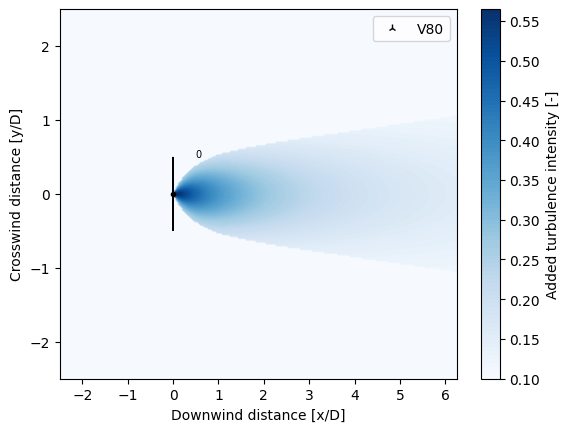

In [4]:
from py_wake.turbulence_models import STF2005TurbulenceModel
plot_turb_map(STF2005TurbulenceModel())

### STF2017TurbulenceModel

Steen Frandsen model implemented according to IEC61400-1, 2017 and weight according to Steen Frandsen's [thesis](https://orbit.dtu.dk/en/publications/turbulence-and-turbulence-generated-structural-loading-in-wind-tu).

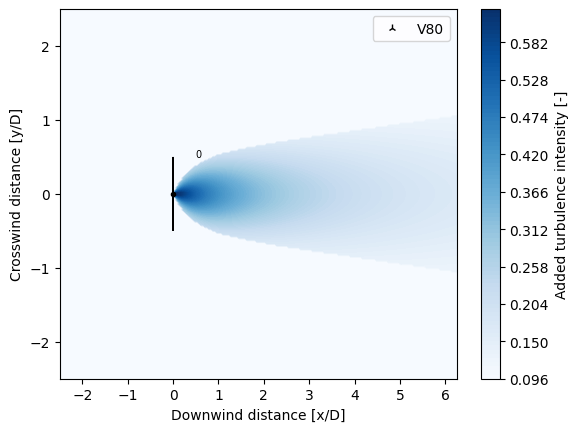

In [5]:
from py_wake.turbulence_models import STF2017TurbulenceModel
plot_turb_map(STF2017TurbulenceModel())

**STF20XXTurbulenceModel with IEC-based spread angle**

The `STF2005TurbulenceModel` and `STF2017TurbulenceModel` take a `weight_function` input which defaults to the bell-shaped `FrandsenWeight` defined in Steen Frandsen's thesis. As an alternative the `IECWeight` applies the full added turbulence in a 21.6$^\circ$ spread angle up to 10 diameter downstream. 

Note, this is a debatable interpretation of the IEC standard which includes a 6% contribution from neighbouring wind turbines when calculating the omni-directional effective turbulence intensity. These 6% maps to a spread angle of 360$^\circ\cdot$ 6% = 21.6$^\circ$.

Note, the IEC standard includes more concepts which is not implemented in PyWake.

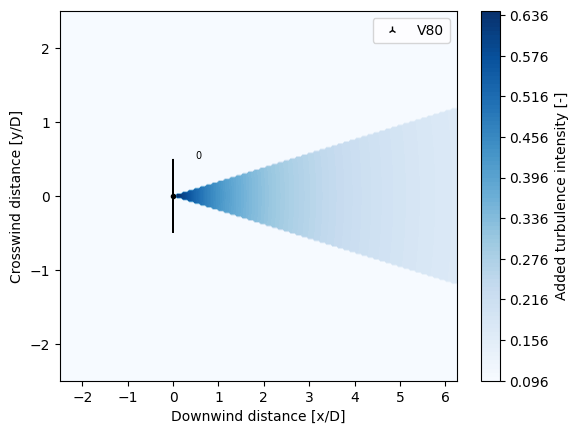

In [6]:
from py_wake.turbulence_models import STF2017TurbulenceModel, IECWeight
from py_wake.superposition_models import SqrMaxSum
plot_turb_map(STF2017TurbulenceModel(addedTurbulenceSuperpositionModel=SqrMaxSum(), 
                                     weight_function=IECWeight(distance_limit=10)))

### GCLTurbulence

Gunner Chr. Larsen model implemented according to:
    
Pierik, J. T. G., Dekker, J. W. M., Braam, H., Bulder, B. H., Winkelaar, D., Larsen, G. C., Morfiadakis, E., Chaviaropoulos, P., Derrick, A., & Molly, J. P. (1999). European wind turbine standards II (EWTS-II). In E. L. Petersen, P. Hjuler Jensen, K. Rave, P. Helm, & H. Ehmann (Eds.), Wind energy for the next millennium. Proceedings (pp. 568-571). James and James Science Publishers.

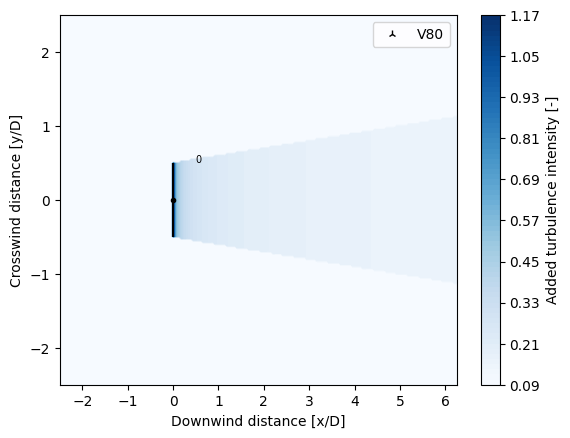

In [7]:
from py_wake.turbulence_models import GCLTurbulence
plot_turb_map(GCLTurbulence())

### CrespoHernandez

Implemented according to: A. Crespo and J. Hernández, Turbulence characteristics in wind-turbine wakes, J. of Wind Eng. and Industrial Aero. 61 (1996) 71-85.

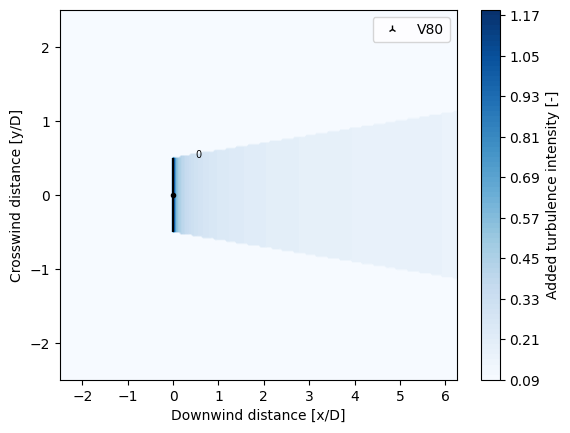

In [8]:
from py_wake.turbulence_models import CrespoHernandez
plot_turb_map(CrespoHernandez())

### Comparing turbulence models

In [9]:
#printing all available wake deficit models in PyWake
from py_wake.utils.model_utils import get_models
from py_wake.turbulence_models.turbulence_model import TurbulenceModel

turbulenceModels = get_models(TurbulenceModel, exclude_None=True)

for model in turbulenceModels:
    print (model.__name__)

CrespoHernandez
GCLTurbulence
STF2005TurbulenceModel
STF2017TurbulenceModel


**1) Turbulence intensity along center line**

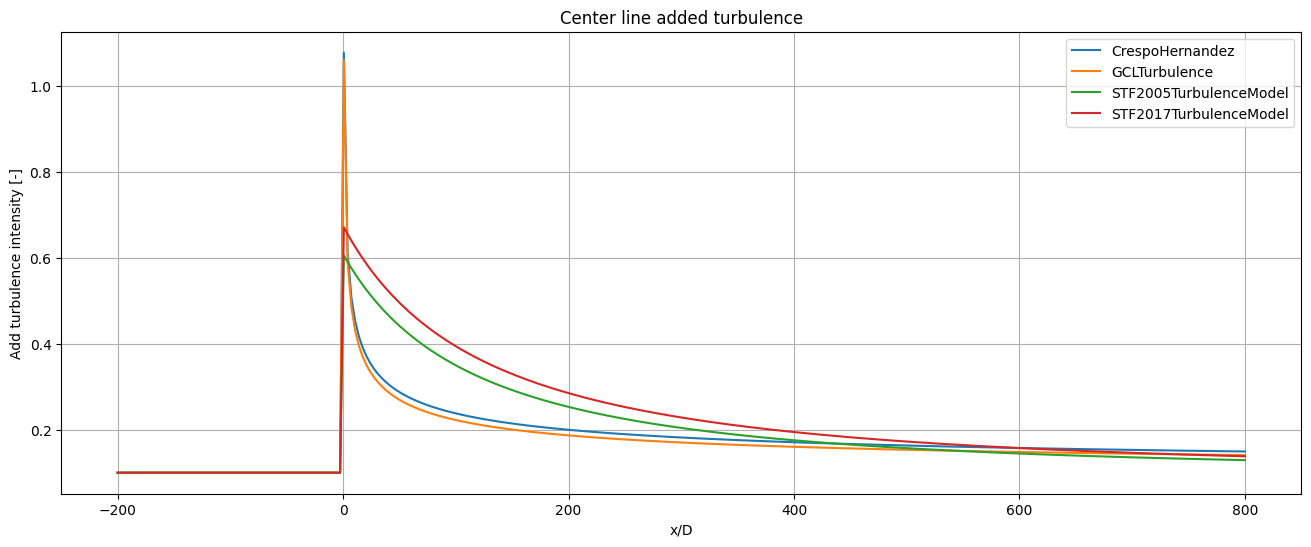

In [10]:
plt.figure(figsize=((16,6)))
for i, model in enumerate(turbulenceModels):
    fm = get_flow_map(NOJDeficit(), turbulenceModel=model(), grid=XYGrid(x=np.linspace(-200,800,300), y=0))
    plt.plot(fm.x, fm.TI_eff.squeeze(), ('-','--')[i//10], label=model.__name__)
setup_plot(title="Center line added turbulence", xlabel='x/D', ylabel='Add turbulence intensity [-]')

**2) Deficit profile 2D downstream**

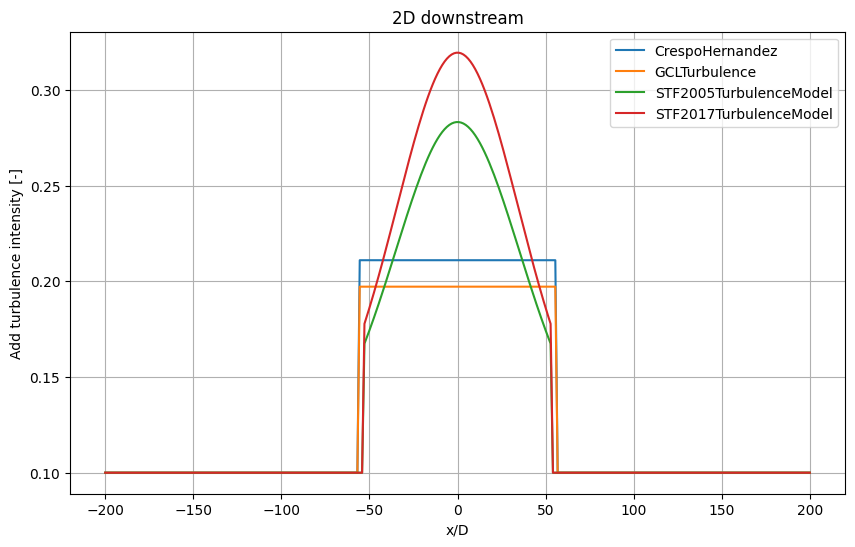

In [11]:
d = 2
plt.figure(figsize=((10,6)))
for i, model in enumerate(turbulenceModels):
    fm = get_flow_map(NOJDeficit(), turbulenceModel=model(), grid=XYGrid(x=d*D, y=np.linspace(-200,200,300)))
    plt.plot(fm.y, fm.TI_eff.squeeze(), ('-','--')[i//10], label=model.__name__)
setup_plot(title="%sD %sstream"%(abs(d),('down','up')[d<0]), xlabel='x/D', ylabel='Add turbulence intensity [-]')